In [1]:
################ select features using random forest and then apply lstm #################

In [2]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [3]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [5]:
n_stocks = 10
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)
# sp500[sp500['Symbol'].isin(portfolio_tickers)]

['DIS', 'BIIB', 'PGR', 'SWK', 'PEP', 'ZION', 'LUV', 'BBWI', 'TFC', 'CBRE']


In [6]:
# tickers = ['AAPL', 'GOOGL', 'MSFT','SPY']
# start_date='2007-01-01'
# end_date='2022-12-31'
# columns = ['Adj Close', 'Volume']
# # Download data
# data = yf.download(tickers, start=start_date, end=end_date)[columns]

# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
# print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    
#     print("the dataframe before the columns were renamed")
#     print(df.columns)
    df_not_renamed=df.copy()
#     df_not_renamed.drop("Open",inplace=True)
#     print(df_not_renamed.columns)
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
#         print(cols)

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
#         print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
#     print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2=df2.shift(1)
# df2.fillna(method='ffill',inplace=True)
# df2.fillna(method='bfill',inplace=True)
df2

[*********************100%%**********************]  10 of 10 completed


,Close_BBWI,Close_BIIB,Close_CBRE,Close_DIS,Close_LUV,Close_PEP,Close_PGR,Close_SWK,Close_TFC,Close_ZION,...,Low_BBWI,Low_BIIB,Low_CBRE,Low_DIS,Low_LUV,Low_PEP,Low_PGR,Low_SWK,Low_TFC,Low_ZION
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,10.077244,49.330002,33.650002,28.317093,14.001653,38.873493,13.773081,34.064178,23.917271,62.279114,...,23.540825,48.200001,33.139999,33.531136,15.350000,62.450001,24.070000,50.049999,43.630001,81.180000
2007-01-05,9.317530,49.750000,33.340000,28.540651,14.218169,39.139999,13.784461,34.278851,23.732464,62.557060,...,21.891672,48.880001,33.099998,33.708706,15.420000,62.500000,24.049999,50.259998,43.299999,82.550003
2007-01-08,9.310716,49.759998,33.099998,28.308819,13.983609,39.016048,13.511386,34.144688,23.417189,62.369240,...,21.147940,49.509998,32.799999,33.531136,15.420000,62.700001,23.600000,50.590000,42.990002,82.599998
2007-01-09,9.130158,50.020000,33.220001,28.565491,14.236215,39.102798,13.602414,34.017223,23.324785,62.474411,...,21.471302,48.910000,32.500000,33.610054,15.340000,62.860001,23.540001,49.950001,42.490002,82.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,39.712482,280.609985,75.680000,86.669998,34.705570,177.378799,128.223221,71.238396,40.566612,46.537743,...,39.709999,278.309998,74.599998,84.690002,35.090000,178.919998,126.320000,71.269997,41.139999,46.970001
2022-12-27,41.287586,279.160004,76.669998,88.010002,35.322170,178.524826,129.060745,71.870193,40.671661,46.701611,...,40.150002,276.070007,75.150002,85.769997,35.180000,180.449997,127.660004,72.599998,42.380001,47.990002
2022-12-28,41.297436,274.769989,76.489998,86.370003,33.217915,179.318237,129.788589,72.327042,40.910400,47.077534,...,41.810001,273.380005,76.099998,85.959999,33.650002,182.270004,129.190002,73.250000,42.340000,47.910000


In [7]:
pd.set_option('display.max_rows', 100)

In [8]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
#         print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        df = pd.DataFrame(data)
        print(ticker)
#         print(df)
        
        stock_df = StockDataFrame.retype(df)
#         print(stock_df)

        stock_df.init_all()
        
#         print("&&&&&&&&&&&&&&&&&&&&&&&&")
#         

#         print(stock_df.columns)
        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)
# print(columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

ticker_dataframes

BBWI
BIIB
CBRE
DIS
LUV
PEP
PGR
SWK
TFC
ZION


,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_rate,BBWI_middle,BBWI_tp,BBWI_boll,BBWI_boll_ub,...,ZION_pgo,ZION_psl,ZION_rsi,ZION_rsv,ZION_stochrsi,ZION_tema,ZION_trix,ZION_wr,ZION_vr,ZION_vwma
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,10.077244,9288633.0,24.252222,24.276476,23.540825,NaN,19.298182,19.298182,10.077244,NaN,...,0.000000,0.000000,NaN,-974.271276,NaN,62.279114,NaN,-1074.271276,NaN,75.526372
2007-01-05,9.317530,17476831.0,22.546482,22.756668,21.891672,-7.538908,17.988623,17.988623,9.697387,10.771785,...,0.011327,8.333333,100.000000,-802.713039,NaN,62.539272,0.070928,-902.713039,inf,75.831292
2007-01-08,9.310716,9970096.0,21.980598,22.433306,21.147940,-0.073131,17.630654,17.630654,9.568496,10.449699,...,-0.002107,8.333333,57.879634,-810.808749,0.000000,62.412936,0.034509,-910.808749,67.897998,75.915830
2007-01-09,9.130158,9207238.0,22.029102,22.465643,21.471302,-1.939241,17.689034,17.689034,9.458912,10.301419,...,0.003184,16.666667,66.411146,-806.275507,20.255076,62.459534,0.024884,-906.275507,141.932793,75.923200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,39.712482,1723600.0,40.529999,40.669998,39.709999,-2.134884,40.030827,40.030827,41.091195,43.659262,...,0.384408,50.000000,47.920368,29.117174,100.000000,46.252758,-0.378479,-79.510129,75.173709,46.867605
2022-12-27,41.287586,2461500.0,40.330002,41.950001,40.150002,3.966269,41.129196,41.129196,41.168474,43.657393,...,0.458510,58.333333,48.757320,32.710768,100.000000,46.760663,-0.358582,-67.289232,87.299143,46.726845
2022-12-28,41.297436,3022500.0,41.939999,42.889999,41.810001,0.023856,41.999146,41.999146,41.261504,43.613206,...,0.565983,58.333333,50.714114,47.763036,100.000000,47.190525,-0.327973,-59.045305,101.682332,46.755063


In [9]:
len(['close', 'volume', 'open', 'high', 'low', 'middle', 'tp','rate',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr', 'log-ret', 'wt1', 'wt2',
       'supertrend_ub', 'supertrend_lb', 'supertrend', 'bop', 'cti', 'eribull',
       'eribear', 'rvgi', 'rvgis', 'kst', 'ao', 'aroon', 'atr', 'cci',
       'change', 'chop', 'cmo', 'coppock', 'dma', 'ichimoku', 'inertia', 'ftr',
       'kama', 'kdjk', 'kdjd', 'kdjj', 'ker', 'mfi', 'ndi', 'pdi', 'pgo',
       'psl', 'rsi', 'rsv', 'stochrsi', 'tema', 'trix', 'wr', 'vr', 'vwma'])

74

In [10]:
# Define the tickers
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
# start='2020-01-01'
# end='2021-01-01'
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# add_factors = quandl.get(tickers, start=start_date, end=end_date)

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
data_quandl['var_wti'] = data_quandl['wti_spot'].pct_change()
# print(data_quandl)

# # Fill NaN values:
# data_quandl.fillna(method='ffill',inplace=True)
# data_quandl.fillna(method='bfill',inplace=True)


# # Print the data
print(data_quandl)



            wti_spot  10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread  \
Date                                                                           
2007-01-02     60.77         -0.12         -0.39     4.94   2.33        0.42   
2007-01-03     58.31         -0.09         -0.38     4.92   2.32        0.44   
2007-01-04     55.65         -0.09         -0.42     4.91   2.30        0.45   
2007-01-05     56.29         -0.11         -0.40     4.92   2.33        0.44   
2007-01-08     56.08         -0.12         -0.42     4.95   2.34        0.41   
...              ...           ...           ...      ...    ...         ...   
2022-07-12       NaN         -0.07          0.74     2.16   1.12         NaN   
2022-07-13       NaN         -0.22          0.52     2.33   1.06         NaN   
2022-07-14       NaN         -0.19          0.56     2.33   1.07         NaN   
2022-07-15       NaN         -0.20          0.56     2.29   1.03         NaN   
2022-07-18       NaN         -0.19      

In [11]:
final_df=pd.merge(ticker_dataframes.reset_index(),data_quandl.reset_index(),on=['Date'],how='inner')

final_df[14:]

,Date,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_rate,BBWI_middle,BBWI_tp,BBWI_boll,...,ZION_wr,ZION_vr,ZION_vwma,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
14,2007-01-24,9.630952,4078018.0,22.691998,23.120453,22.675829,-0.070721,18.475745,18.475745,9.515124,...,-730.536934,69.860722,76.208188,54.24,-0.12,-0.32,5.00,2.39,0.36,0.011752
15,2007-01-25,9.641174,3377257.0,22.789005,23.088116,22.732416,0.106141,18.487235,18.487235,9.523527,...,-983.459038,82.013999,76.278475,53.49,-0.11,-0.27,5.01,2.43,0.35,-0.013827
16,2007-01-26,9.467430,3347569.0,22.942602,22.942602,22.376719,-1.802106,18.262250,18.262250,9.520021,...,-901.867636,71.886555,76.313864,55.38,-0.11,-0.25,5.00,2.44,0.36,0.035334
17,2007-01-29,9.409514,4071214.0,22.457560,22.562653,22.093775,-0.611736,18.021981,18.021981,9.513521,...,-808.933225,85.796616,76.427397,54.01,-0.09,-0.24,5.01,2.46,0.35,-0.024738
18,2007-01-30,9.389073,2294759.0,22.231205,22.400970,22.126112,-0.217238,17.972052,17.972052,9.506607,...,-821.548503,79.085664,76.509978,57.03,-0.10,-0.25,5.00,2.43,0.36,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,26.201677,3432900.0,27.410000,27.600000,26.719999,-2.534384,26.840559,26.840559,29.102157,...,-129.935710,90.144869,50.897293,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,26.133541,3131200.0,26.799999,27.610001,26.680000,-0.260045,26.807847,26.807847,28.760036,...,-134.471357,80.234414,50.636454,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,26.678600,3244200.0,26.450001,27.540001,26.080000,2.085669,26.766200,26.766200,28.495294,...,-131.002559,78.202349,50.358802,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,25.267290,4278500.0,26.870001,27.020000,25.809999,-5.290046,26.032430,26.032430,28.162420,...,-130.490718,70.416328,50.174190,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [12]:
pd.DataFrame(final_df.isnull().sum()).sort_values(by=0,ascending=False)


,0
ZION_supertrend_ub,3912
DIS_supertrend_ub,3912
LUV_supertrend_lb,3912
LUV_supertrend_ub,3912
PGR_supertrend_lb,3912
...,...
PEP_rsv,0
PGR_qqe,0
PGR_qqel,0
PGR_qqes,0


In [13]:
final_df2=final_df.copy()

for ticker in tickers:
    final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
#     final_df2.drop(columns=[ticker+"_cr",ticker+"_cr-ma1",ticker+"_cr-ma2",ticker+"_cr-ma3"],inplace=True)
#     print(final_df2)
#     final_df2=final_df2.dropna(subset=[ticker+"_close",ticker+"_close_14_sma",ticker+"_close_14_roc",ticker+"_boll_ub",ticker+"_boll_lb",ticker+"_boll"])
final_df2.fillna(method='ffill',inplace=True)
final_df2.fillna(method='bfill',inplace=True)

final_df2=final_df2.loc[14:]
final_df2.set_index(['Date'],inplace=True)

final_df2

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_rate,BBWI_middle,BBWI_tp,BBWI_boll,BBWI_boll_ub,...,ZION_wr,ZION_vr,ZION_vwma,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,-0.000707,4078018.0,22.691998,23.120453,22.675829,-0.070721,18.475745,18.475745,9.515124,10.029696,...,-730.536934,69.860722,76.208188,54.24,-0.12,-0.32,5.00,2.39,0.36,0.011752
2007-01-25,0.001061,3377257.0,22.789005,23.088116,22.732416,0.106141,18.487235,18.487235,9.523527,10.023635,...,-983.459038,82.013999,76.278475,53.49,-0.11,-0.27,5.01,2.43,0.35,-0.013827
2007-01-26,-0.018021,3347569.0,22.942602,22.942602,22.376719,-1.802106,18.262250,18.262250,9.520021,10.003985,...,-901.867636,71.886555,76.313864,55.38,-0.11,-0.25,5.00,2.44,0.36,0.035334
2007-01-29,-0.006117,4071214.0,22.457560,22.562653,22.093775,-0.611736,18.021981,18.021981,9.513521,9.985173,...,-808.933225,85.796616,76.427397,54.01,-0.09,-0.24,5.01,2.46,0.35,-0.024738
2007-01-30,-0.002172,2294759.0,22.231205,22.400970,22.126112,-0.217238,17.972052,17.972052,9.506607,9.967922,...,-821.548503,79.085664,76.509978,57.03,-0.10,-0.25,5.00,2.43,0.36,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,-0.025344,3432900.0,27.410000,27.600000,26.719999,-2.534384,26.840559,26.840559,29.102157,34.158110,...,-129.935710,90.144869,50.897293,89.32,-0.07,0.74,2.16,1.12,0.09,0.000000
2022-07-13,-0.002600,3131200.0,26.799999,27.610001,26.680000,-0.260045,26.807847,26.807847,28.760036,33.635065,...,-134.471357,80.234414,50.636454,89.32,-0.22,0.52,2.33,1.06,0.09,0.000000
2022-07-14,0.020857,3244200.0,26.450001,27.540001,26.080000,2.085669,26.766200,26.766200,28.495294,33.207936,...,-131.002559,78.202349,50.358802,89.32,-0.19,0.56,2.33,1.07,0.09,0.000000


In [14]:

pd.DataFrame(np.isinf(final_df2).sum()).sort_values(by=0,ascending=False).head(50)

,0
PEP_cr,3333
TFC_cr,3099
PGR_cr,3010
SWK_cr,2694
BBWI_cr,2582
ZION_cr,2261
DIS_cr,1552
LUV_cr,348
BBWI_close,0
PGR_kama,0


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    # AAPL_df.drop(columns=["AAPL_cr"],inplace=True)
    
    null_count=pd.DataFrame(df.isnull().sum()).sort_values(by=0,ascending=False).reset_index()
    null_count.columns=['features','nulls']
    null_count.head()
    threshold = len(df)/100

    # Get the column names with too many negative values
    columns_to_drop = null_count[null_count['nulls'] > threshold]['features'].tolist()
    print(columns_to_drop)
    # Drop the columns
    df.drop(columns=columns_to_drop, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)

#     print(pd.DataFrame(df.isnull().sum()).sort_values(by=0,ascending=False).reset_index())
    
    
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("**************************")
#     print(df.isnull())

    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
#     y=scaler.fit_transform(y).reshape(-1, 1)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
#     print(X_train)
#     print("***************")
#     print(y_train)

    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
#     print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))

    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [16]:
final_df2.head(2)
features=['close', 'volume', 'open', 'high', 'low', 'middle', 'tp','rate',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr', 'log-ret', 'wt1', 'wt2',
       'supertrend_ub', 'supertrend_lb', 'supertrend', 'bop', 'cti', 'eribull',
       'eribear', 'rvgi', 'rvgis', 'kst', 'ao', 'aroon', 'atr', 'cci',
       'change', 'chop', 'cmo', 'coppock', 'dma', 'ichimoku', 'inertia', 'ftr',
       'kama', 'kdjk', 'kdjd', 'kdjj', 'ker', 'mfi', 'ndi', 'pdi', 'pgo',
       'psl', 'rsi', 'rsv', 'stochrsi', 'tema', 'trix', 'wr', 'vr', 'vwma']
feat_importance_all=pd.DataFrame()
feat_importance_all['Features']=features
print(feat_importance_all)
for ticker in tickers:

    matching_columns = [col for col in final_df2.columns if ticker in col]

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=feat_importance_all.merge(feat_importance_temp, on=['Features'], how='outer')
#     print(feat_importance_all)
# feature_importance_info.sort(key=lambda x: x[0],reverse=True)

feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
feat_importance_all=feat_importance_all.sort_values(by=['Average_relative_Importance'], ascending=False)
print(feat_importance_all)

# feature_importance_info.sort(key=lambda x: x[0],reverse=True)


         Features
0           close
1          volume
2            open
3            high
4             low
5          middle
6              tp
7            rate
8            boll
9         boll_ub
10        boll_lb
11           macd
12          macds
13          macdh
14            pvo
15           pvos
16           pvoh
17            ppo
18           ppos
19           ppoh
20            qqe
21           qqel
22           qqes
23             cr
24         cr-ma1
25         cr-ma2
26         cr-ma3
27             tr
28             dx
29            adx
30           adxr
31        log-ret
32            wt1
33            wt2
34  supertrend_ub
35  supertrend_lb
36     supertrend
37            bop
38            cti
39        eribull
40        eribear
41           rvgi
42          rvgis
43            kst
44             ao
45          aroon
46            atr
47            cci
48         change
49           chop
50            cmo
51        coppock
52            dma
53       ichimoku
54        

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['BIIB_supertrend_lb', 'BIIB_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['PGR_supertrend_lb', 'PGR_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['SWK_supertrend_lb', 'SWK_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['PEP_supertrend_lb', 'PEP_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['ZION_supertrend_lb', 'ZION_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['LUV_supertrend_lb', 'LUV_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['BBWI_supertrend_lb', 'BBWI_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['TFC_supertrend_lb', 'TFC_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

['CBRE_supertrend_lb', 'CBRE_supertrend_ub']
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/2375761966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

         Features DIS_Relative_Importance BIIB_Relative_Importance  \
65            psl                0.003002                 0.105625   
60            ker                0.007258                 0.006005   
72             vr                0.006618                 0.009025   
27             tr                0.005147                 0.008294   
31        log-ret                0.012927                 0.001869   
19           ppoh                0.002599                 0.001809   
16           pvoh                0.005202                 0.002923   
37            bop                0.003276                 0.013717   
1          volume                0.006404                 0.006304   
53       ichimoku                0.006783                 0.004114   
0           close                0.006864                 0.003452   
48         change                0.006975                 0.002759   
18           ppos                0.004429                 0.000507   
15           pvos   

In [17]:
imp_features=list(feat_importance_all['Features'][:15])
imp_features
# feat_importance_all

['psl',
 'ker',
 'vr',
 'tr',
 'log-ret',
 'ppoh',
 'pvoh',
 'bop',
 'volume',
 'ichimoku',
 'close',
 'change',
 'ppos',
 'pvos',
 'rate']

In [18]:
# imp_col_names=[filtered_df['Features'].values][0].tolist()

# imp_col_names = [ticker +"_"+ element for element in imp_col_names]
imp_features.append('close') if 'close' not in imp_features else imp_features
final_col_names = []
for col in imp_features:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['DIS_psl', 'BIIB_psl', 'PGR_psl', 'SWK_psl', 'PEP_psl', 'ZION_psl', 'LUV_psl', 'BBWI_psl', 'TFC_psl', 'CBRE_psl', 'DIS_ker', 'BIIB_ker', 'PGR_ker', 'SWK_ker', 'PEP_ker', 'ZION_ker', 'LUV_ker', 'BBWI_ker', 'TFC_ker', 'CBRE_ker', 'DIS_vr', 'BIIB_vr', 'PGR_vr', 'SWK_vr', 'PEP_vr', 'ZION_vr', 'LUV_vr', 'BBWI_vr', 'TFC_vr', 'CBRE_vr', 'DIS_tr', 'BIIB_tr', 'PGR_tr', 'SWK_tr', 'PEP_tr', 'ZION_tr', 'LUV_tr', 'BBWI_tr', 'TFC_tr', 'CBRE_tr', 'DIS_log-ret', 'BIIB_log-ret', 'PGR_log-ret', 'SWK_log-ret', 'PEP_log-ret', 'ZION_log-ret', 'LUV_log-ret', 'BBWI_log-ret', 'TFC_log-ret', 'CBRE_log-ret', 'DIS_ppoh', 'BIIB_ppoh', 'PGR_ppoh', 'SWK_ppoh', 'PEP_ppoh', 'ZION_ppoh', 'LUV_ppoh', 'BBWI_ppoh', 'TFC_ppoh', 'CBRE_ppoh', 'DIS_pvoh', 'BIIB_pvoh', 'PGR_pvoh', 'SWK_pvoh', 'PEP_pvoh', 'ZION_pvoh', 'LUV_pvoh', 'BBWI_pvoh', 'TFC_pvoh', 'CBRE_pvoh', 'DIS_bop', 'BIIB_bop', 'PGR_bop', 'SWK_bop', 'PEP_bop', 'ZION_bop', 'LUV_bop', 'BBWI_bop', 'TFC_bop', 'CBRE_bop', 'DIS_volume', 'BIIB_volume', 'PGR_volume', 'SWK

In [19]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit','var_wti']

In [20]:
final_col_names

['DIS_psl',
 'BIIB_psl',
 'PGR_psl',
 'SWK_psl',
 'PEP_psl',
 'ZION_psl',
 'LUV_psl',
 'BBWI_psl',
 'TFC_psl',
 'CBRE_psl',
 'DIS_ker',
 'BIIB_ker',
 'PGR_ker',
 'SWK_ker',
 'PEP_ker',
 'ZION_ker',
 'LUV_ker',
 'BBWI_ker',
 'TFC_ker',
 'CBRE_ker',
 'DIS_vr',
 'BIIB_vr',
 'PGR_vr',
 'SWK_vr',
 'PEP_vr',
 'ZION_vr',
 'LUV_vr',
 'BBWI_vr',
 'TFC_vr',
 'CBRE_vr',
 'DIS_tr',
 'BIIB_tr',
 'PGR_tr',
 'SWK_tr',
 'PEP_tr',
 'ZION_tr',
 'LUV_tr',
 'BBWI_tr',
 'TFC_tr',
 'CBRE_tr',
 'DIS_log-ret',
 'BIIB_log-ret',
 'PGR_log-ret',
 'SWK_log-ret',
 'PEP_log-ret',
 'ZION_log-ret',
 'LUV_log-ret',
 'BBWI_log-ret',
 'TFC_log-ret',
 'CBRE_log-ret',
 'DIS_ppoh',
 'BIIB_ppoh',
 'PGR_ppoh',
 'SWK_ppoh',
 'PEP_ppoh',
 'ZION_ppoh',
 'LUV_ppoh',
 'BBWI_ppoh',
 'TFC_ppoh',
 'CBRE_ppoh',
 'DIS_pvoh',
 'BIIB_pvoh',
 'PGR_pvoh',
 'SWK_pvoh',
 'PEP_pvoh',
 'ZION_pvoh',
 'LUV_pvoh',
 'BBWI_pvoh',
 'TFC_pvoh',
 'CBRE_pvoh',
 'DIS_bop',
 'BIIB_bop',
 'PGR_bop',
 'SWK_bop',
 'PEP_bop',
 'ZION_bop',
 'LUV_bop',
 'BBWI

In [21]:

model_data=final_df[['Date']+final_col_names]

model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)


# model_data.set_index(['Date'],inplace=True)
for ticker in tickers:
    model_data[ticker+"_close"] = model_data[ticker+"_close"].pct_change()
#     print(model_data)
model_data=model_data.loc[14:]

model_data=model_data.set_index('Date')
model_data

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/1422420579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/1422420579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/1422420579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,DIS_psl,BIIB_psl,PGR_psl,SWK_psl,PEP_psl,ZION_psl,LUV_psl,BBWI_psl,TFC_psl,CBRE_psl,...,ZION_rate,LUV_rate,BBWI_rate,TFC_rate,CBRE_rate,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,58.333333,58.333333,33.333333,75.000000,58.333333,33.333333,58.333333,41.666667,41.666667,58.333333,...,-0.084802,-0.902651,-0.070721,0.070229,1.807908,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,58.333333,50.000000,41.666667,83.333333,66.666667,41.666667,58.333333,50.000000,50.000000,66.666667,...,1.200385,-0.520492,0.106141,0.514254,2.968922,-0.11,-0.27,5.01,2.43,-0.013827
2007-01-26,50.000000,41.666667,41.666667,83.333333,58.333333,33.333333,50.000000,50.000000,50.000000,58.333333,...,-0.347436,-1.046396,-1.802106,-1.837222,-4.661815,-0.11,-0.25,5.00,2.44,0.035334
2007-01-29,50.000000,41.666667,50.000000,83.333333,58.333333,33.333333,41.666667,41.666667,50.000000,58.333333,...,1.587082,-0.330507,-0.611736,-0.047347,0.706614,-0.09,-0.24,5.01,2.46,-0.024738
2007-01-30,50.000000,50.000000,58.333333,75.000000,58.333333,25.000000,41.666667,41.666667,41.666667,58.333333,...,-0.520784,0.397902,-0.217238,-0.331868,3.873133,-0.10,-0.25,5.00,2.43,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,41.666667,75.000000,50.000000,50.000000,58.333333,33.333333,41.666667,33.333333,41.666667,58.333333,...,-1.234330,0.354206,-2.534384,-0.628932,-0.145024,-0.07,0.74,2.16,1.12,0.000000
2022-07-13,33.333333,75.000000,50.000000,41.666667,50.000000,33.333333,41.666667,33.333333,41.666667,58.333333,...,-0.416578,4.642963,-0.260045,-0.400846,1.082651,-0.22,0.52,2.33,1.06,0.000000
2022-07-14,25.000000,66.666667,50.000000,41.666667,50.000000,25.000000,41.666667,33.333333,33.333333,50.000000,...,-1.254984,0.674620,2.085669,-2.330012,-1.724138,-0.19,0.56,2.33,1.07,0.000000


In [22]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [23]:
label_cols=[col for col in model_data.columns if "close" in col ]
label_cols

['DIS_close',
 'BIIB_close',
 'PGR_close',
 'SWK_close',
 'PEP_close',
 'ZION_close',
 'LUV_close',
 'BBWI_close',
 'TFC_close',
 'CBRE_close']

In [24]:


# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

In [25]:
model_data.columns

Index(['DIS_psl', 'BIIB_psl', 'PGR_psl', 'SWK_psl', 'PEP_psl', 'ZION_psl',
       'LUV_psl', 'BBWI_psl', 'TFC_psl', 'CBRE_psl',
       ...
       'ZION_rate', 'LUV_rate', 'BBWI_rate', 'TFC_rate', 'CBRE_rate',
       '10y2y_spread', '10y3m_spread', '3m_rate', 'ltiit', 'var_wti'],
      dtype='object', length=155)

In [26]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['DIS_close', 'BIIB_close', 'PGR_close', 'SWK_close', 'PEP_close', 'ZION_close', 'LUV_close', 'BBWI_close', 'TFC_close', 'CBRE_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 155)
Train target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 155)
Validation target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Test input shape: (391, 5, 1

In [27]:
num_features

155

In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np


Training with initial learning rate: 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 155)            620       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1368064   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3601782 (13.74 MB)
Trainable params: 3601472 (13.74 MB)
Non-trainable params: 310 (1.21 KB)
________________

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 4s 604ms/step - loss: 0.0020 - root_mean_squared_error: 0.0631 - mae: 0.0477 - val_loss: 0.0070 - val_root_mean_squared_error: 0.1183 - val_mae: 0.0964 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 7.8926e-04 - root_mean_squared_error: 0.0399 - mae: 0.0300
Epoch 2: Learning Rate = 0.0010000000474974513, Loss = 0.0007892617140896618

Epoch 2: val_loss improved from 0.00701 to 0.00338, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 533ms/step - loss: 7.8926e-04 - root_mean_squared_error: 0.0399 - mae: 0.0300 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0822 - val_mae: 0.0653 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 5.7374e-04 - root_mean_squared_error: 0.0340 - mae: 0.0248
Epoch 3: Learning Rate = 0.0010000000474974513, Loss = 0.000573738943785429

Epoch 3: val_loss improved from 0.00338 to 0.00281, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 558ms/step - loss: 5.7374e-04 - root_mean_squared_error: 0.0340 - mae: 0.0248 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0750 - val_mae: 0.0596 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 4.6186e-04 - root_mean_squared_error: 0.0305 - mae: 0.0216
Epoch 4: Learning Rate = 0.0010000000474974513, Loss = 0.00046186105464585125

Epoch 4: val_loss improved from 0.00281 to 0.00233, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 548ms/step - loss: 4.6186e-04 - root_mean_squared_error: 0.0305 - mae: 0.0216 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0684 - val_mae: 0.0540 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 3.9837e-04 - root_mean_squared_error: 0.0281 - mae: 0.0192
Epoch 5: Learning Rate = 0.0010000000474974513, Loss = 0.00039836933137848973

Epoch 5: val_loss improved from 0.00233 to 0.00169, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 532ms/step - loss: 3.9837e-04 - root_mean_squared_error: 0.0281 - mae: 0.0192 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0580 - val_mae: 0.0450 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 3.6550e-04 - root_mean_squared_error: 0.0271 - mae: 0.0179
Epoch 6: Learning Rate = 0.0010000000474974513, Loss = 0.00036549996002577245

Epoch 6: val_loss improved from 0.00169 to 0.00162, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.6550e-04 - root_mean_squared_error: 0.0271 - mae: 0.0179 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0567 - val_mae: 0.0444 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 3.4636e-04 - root_mean_squared_error: 0.0264 - mae: 0.0171
Epoch 7: Learning Rate = 0.0010000000474974513, Loss = 0.00034635874908417463

Epoch 7: val_loss improved from 0.00162 to 0.00139, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 563ms/step - loss: 3.4636e-04 - root_mean_squared_error: 0.0264 - mae: 0.0171 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0528 - val_mae: 0.0409 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 3.3515e-04 - root_mean_squared_error: 0.0261 - mae: 0.0166
Epoch 8: Learning Rate = 0.0010000000474974513, Loss = 0.00033515196992084384

Epoch 8: val_loss improved from 0.00139 to 0.00121, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 554ms/step - loss: 3.3515e-04 - root_mean_squared_error: 0.0261 - mae: 0.0166 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0492 - val_mae: 0.0376 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 3.2760e-04 - root_mean_squared_error: 0.0254 - mae: 0.0161
Epoch 9: Learning Rate = 0.0010000000474974513, Loss = 0.00032760112662799656

Epoch 9: val_loss improved from 0.00121 to 0.00116, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 534ms/step - loss: 3.2760e-04 - root_mean_squared_error: 0.0254 - mae: 0.0161 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0484 - val_mae: 0.0369 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 3.2228e-04 - root_mean_squared_error: 0.0255 - mae: 0.0159
Epoch 10: Learning Rate = 0.0010000000474974513, Loss = 0.00032227844349108636

Epoch 10: val_loss improved from 0.00116 to 0.00108, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.2228e-04 - root_mean_squared_error: 0.0255 - mae: 0.0159 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0465 - val_mae: 0.0353 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 3.1864e-04 - root_mean_squared_error: 0.0252 - mae: 0.0157
Epoch 11: Learning Rate = 0.0009000000427477062, Loss = 0.00031863717595115304

Epoch 11: val_loss improved from 0.00108 to 0.00103, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 550ms/step - loss: 3.1864e-04 - root_mean_squared_error: 0.0252 - mae: 0.0157 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0452 - val_mae: 0.0341 - lr: 9.0000e-04
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 3.1695e-04 - root_mean_squared_error: 0.0251 - mae: 0.0156
Epoch 12: Learning Rate = 0.0009000000427477062, Loss = 0.00031695113284513354

Epoch 12: val_loss improved from 0.00103 to 0.00097, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 542ms/step - loss: 3.1695e-04 - root_mean_squared_error: 0.0251 - mae: 0.0156 - val_loss: 9.7225e-04 - val_root_mean_squared_error: 0.0440 - val_mae: 0.0331 - lr: 9.0000e-04
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 3.1609e-04 - root_mean_squared_error: 0.0253 - mae: 0.0156
Epoch 13: Learning Rate = 0.0009000000427477062, Loss = 0.0003160850901622325

Epoch 13: val_loss improved from 0.00097 to 0.00095, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 566ms/step - loss: 3.1609e-04 - root_mean_squared_error: 0.0253 - mae: 0.0156 - val_loss: 9.4682e-04 - val_root_mean_squared_error: 0.0433 - val_mae: 0.0325 - lr: 9.0000e-04
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 3.1397e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154
Epoch 14: Learning Rate = 0.0009000000427477062, Loss = 0.00031396630220115185

Epoch 14: val_loss improved from 0.00095 to 0.00090, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 551ms/step - loss: 3.1397e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154 - val_loss: 8.9688e-04 - val_root_mean_squared_error: 0.0425 - val_mae: 0.0316 - lr: 9.0000e-04
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 3.1315e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154
Epoch 15: Learning Rate = 0.0009000000427477062, Loss = 0.00031314537045545876

Epoch 15: val_loss improved from 0.00090 to 0.00088, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 559ms/step - loss: 3.1315e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154 - val_loss: 8.7795e-04 - val_root_mean_squared_error: 0.0422 - val_mae: 0.0314 - lr: 9.0000e-04
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 3.1312e-04 - root_mean_squared_error: 0.0246 - mae: 0.0153
Epoch 16: Learning Rate = 0.0009000000427477062, Loss = 0.00031312217470258474

Epoch 16: val_loss improved from 0.00088 to 0.00085, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 530ms/step - loss: 3.1312e-04 - root_mean_squared_error: 0.0246 - mae: 0.0153 - val_loss: 8.5154e-04 - val_root_mean_squared_error: 0.0416 - val_mae: 0.0308 - lr: 9.0000e-04
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 3.1482e-04 - root_mean_squared_error: 0.0252 - mae: 0.0155
Epoch 17: Learning Rate = 0.0009000000427477062, Loss = 0.0003148219839204103

Epoch 17: val_loss did not improve from 0.00085
6/6 [==============================] - 1s 214ms/step - loss: 3.1482e-04 - root_mean_squared_error: 0.0252 - mae: 0.0155 - val_loss: 8.5309e-04 - val_root_mean_squared_error: 0.0416 - val_mae: 0.0310 - lr: 9.0000e-04
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 3.1262e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Epoch 18: Learning Rate = 0.0009000000427477062, Loss = 0.000312615477014333

Epoch 18: val_loss improved from 0.00085 to 0.00080, saving model to best_model_v2
INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 580ms/step - loss: 3.1262e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 8.0293e-04 - val_root_mean_squared_error: 0.0405 - val_mae: 0.0300 - lr: 9.0000e-04
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 3.1231e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154
Epoch 19: Learning Rate = 0.0009000000427477062, Loss = 0.00031230523018166423

Epoch 19: val_loss improved from 0.00080 to 0.00080, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 558ms/step - loss: 3.1231e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154 - val_loss: 7.9769e-04 - val_root_mean_squared_error: 0.0399 - val_mae: 0.0295 - lr: 9.0000e-04
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 3.1256e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154
Epoch 20: Learning Rate = 0.0009000000427477062, Loss = 0.00031256111105903983

Epoch 20: val_loss improved from 0.00080 to 0.00079, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 533ms/step - loss: 3.1256e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154 - val_loss: 7.8878e-04 - val_root_mean_squared_error: 0.0397 - val_mae: 0.0295 - lr: 9.0000e-04
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 3.1257e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Epoch 21: Learning Rate = 0.00072900002123788, Loss = 0.00031256917282007635

Epoch 21: val_loss improved from 0.00079 to 0.00076, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 580ms/step - loss: 3.1257e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 7.6018e-04 - val_root_mean_squared_error: 0.0390 - val_mae: 0.0287 - lr: 7.2900e-04
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 3.1214e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154
Epoch 22: Learning Rate = 0.00072900002123788, Loss = 0.0003121388144791126

Epoch 22: val_loss improved from 0.00076 to 0.00075, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 553ms/step - loss: 3.1214e-04 - root_mean_squared_error: 0.0250 - mae: 0.0154 - val_loss: 7.5443e-04 - val_root_mean_squared_error: 0.0389 - val_mae: 0.0286 - lr: 7.2900e-04
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 3.1128e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152
Epoch 23: Learning Rate = 0.00072900002123788, Loss = 0.00031127783586271107

Epoch 23: val_loss improved from 0.00075 to 0.00074, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 567ms/step - loss: 3.1128e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152 - val_loss: 7.3891e-04 - val_root_mean_squared_error: 0.0383 - val_mae: 0.0282 - lr: 7.2900e-04
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 3.1068e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152
Epoch 24: Learning Rate = 0.00072900002123788, Loss = 0.0003106777439825237

Epoch 24: val_loss improved from 0.00074 to 0.00073, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 529ms/step - loss: 3.1068e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152 - val_loss: 7.2970e-04 - val_root_mean_squared_error: 0.0382 - val_mae: 0.0280 - lr: 7.2900e-04
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 3.1099e-04 - root_mean_squared_error: 0.0251 - mae: 0.0153
Epoch 25: Learning Rate = 0.00072900002123788, Loss = 0.000310993695165962

Epoch 25: val_loss improved from 0.00073 to 0.00073, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 564ms/step - loss: 3.1099e-04 - root_mean_squared_error: 0.0251 - mae: 0.0153 - val_loss: 7.2518e-04 - val_root_mean_squared_error: 0.0381 - val_mae: 0.0280 - lr: 7.2900e-04
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 3.1081e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Epoch 26: Learning Rate = 0.00072900002123788, Loss = 0.0003108138917014003

Epoch 26: val_loss improved from 0.00073 to 0.00071, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 552ms/step - loss: 3.1081e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 7.0714e-04 - val_root_mean_squared_error: 0.0373 - val_mae: 0.0273 - lr: 7.2900e-04
Epoch 27/100
6/6 [==============================] - ETA: 0s - loss: 3.1209e-04 - root_mean_squared_error: 0.0248 - mae: 0.0152
Epoch 27: Learning Rate = 0.00072900002123788, Loss = 0.0003120854089502245

Epoch 27: val_loss did not improve from 0.00071
6/6 [==============================] - 1s 212ms/step - loss: 3.1209e-04 - root_mean_squared_error: 0.0248 - mae: 0.0152 - val_loss: 7.1623e-04 - val_root_mean_squared_error: 0.0383 - val_mae: 0.0280 - lr: 7.2900e-04
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 3.1110e-04 - root_mean_squared_error: 0.0249 - mae: 0.0153
Epoch 28: Learning Rate = 0.00072900002123788, Loss = 0.0003111035912297666

Epoch 28: val_loss improved from 0.00071 to 0.00070, saving model to best_model_v2
INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 556ms/step - loss: 3.1110e-04 - root_mean_squared_error: 0.0249 - mae: 0.0153 - val_loss: 6.9656e-04 - val_root_mean_squared_error: 0.0375 - val_mae: 0.0272 - lr: 7.2900e-04
Epoch 29/100
6/6 [==============================] - ETA: 0s - loss: 3.1108e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Epoch 29: Learning Rate = 0.00072900002123788, Loss = 0.0003110823454335332

Epoch 29: val_loss improved from 0.00070 to 0.00069, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 541ms/step - loss: 3.1108e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 6.8689e-04 - val_root_mean_squared_error: 0.0372 - val_mae: 0.0271 - lr: 7.2900e-04
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 3.0982e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152
Epoch 30: Learning Rate = 0.00072900002123788, Loss = 0.00030982104362919927

Epoch 30: val_loss improved from 0.00069 to 0.00068, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 566ms/step - loss: 3.0982e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152 - val_loss: 6.8337e-04 - val_root_mean_squared_error: 0.0370 - val_mae: 0.0269 - lr: 7.2900e-04
Epoch 31/100
6/6 [==============================] - ETA: 0s - loss: 3.0983e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152
Epoch 31: Learning Rate = 0.0005314410082064569, Loss = 0.0003098281449638307

Epoch 31: val_loss improved from 0.00068 to 0.00067, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 554ms/step - loss: 3.0983e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152 - val_loss: 6.6724e-04 - val_root_mean_squared_error: 0.0369 - val_mae: 0.0268 - lr: 5.3144e-04
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 3.0951e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152
Epoch 32: Learning Rate = 0.0005314410082064569, Loss = 0.0003095127467531711

Epoch 32: val_loss did not improve from 0.00067
6/6 [==============================] - 1s 213ms/step - loss: 3.0951e-04 - root_mean_squared_error: 0.0250 - mae: 0.0152 - val_loss: 6.7407e-04 - val_root_mean_squared_error: 0.0362 - val_mae: 0.0266 - lr: 5.3144e-04
Epoch 33/100
6/6 [==============================] - ETA: 0s - loss: 3.0887e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Epoch 33: Learning Rate = 0.0005314410082064569, Loss = 0.000308871065499261

Epoch 33: val_loss improved from 0.00067 to 0.00066, saving model to best_model_v2
INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 535ms/step - loss: 3.0887e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 6.6496e-04 - val_root_mean_squared_error: 0.0365 - val_mae: 0.0264 - lr: 5.3144e-04


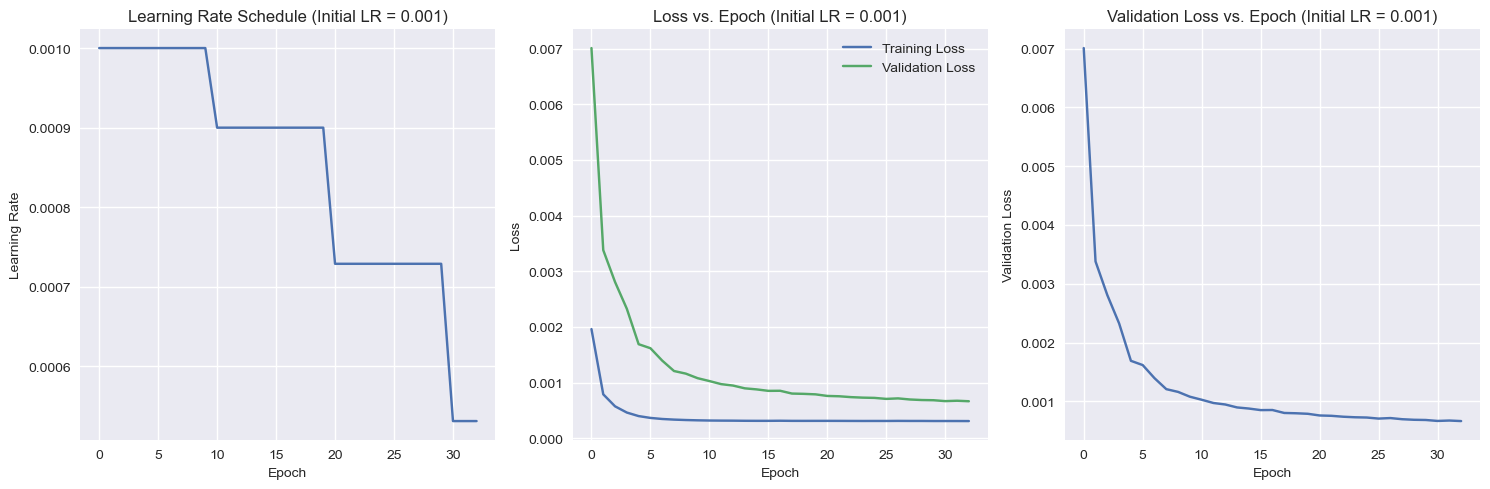


Training with initial learning rate: 0.01


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 155)            620       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1368064   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3601782 (13.74 MB)
Trainable params: 3601472 (13.74 MB)
Non-trainable params: 310 (1.21 KB)
______________

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 560ms/step - loss: 5.1374e-04 - root_mean_squared_error: 0.0324 - mae: 0.0214 - val_loss: 4.5657e-04 - val_root_mean_squared_error: 0.0296 - val_mae: 0.0193 - lr: 0.0100
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 3.4155e-04 - root_mean_squared_error: 0.0262 - mae: 0.0171
Epoch 3: Learning Rate = 0.009999999776482582, Loss = 0.00034155260073021054

Epoch 3: val_loss improved from 0.00046 to 0.00039, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 526ms/step - loss: 3.4155e-04 - root_mean_squared_error: 0.0262 - mae: 0.0171 - val_loss: 3.9094e-04 - val_root_mean_squared_error: 0.0277 - val_mae: 0.0174 - lr: 0.0100
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 3.2467e-04 - root_mean_squared_error: 0.0255 - mae: 0.0161
Epoch 4: Learning Rate = 0.009999999776482582, Loss = 0.00032467072014696896

Epoch 4: val_loss improved from 0.00039 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 567ms/step - loss: 3.2467e-04 - root_mean_squared_error: 0.0255 - mae: 0.0161 - val_loss: 3.6438e-04 - val_root_mean_squared_error: 0.0263 - val_mae: 0.0159 - lr: 0.0100
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 3.0642e-04 - root_mean_squared_error: 0.0247 - mae: 0.0150
Epoch 5: Learning Rate = 0.009999999776482582, Loss = 0.0003064176707994193

Epoch 5: val_loss did not improve from 0.00036
6/6 [==============================] - 1s 208ms/step - loss: 3.0642e-04 - root_mean_squared_error: 0.0247 - mae: 0.0150 - val_loss: 3.6539e-04 - val_root_mean_squared_error: 0.0266 - val_mae: 0.0160 - lr: 0.0100
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 3.1008e-04 - root_mean_squared_error: 0.0248 - mae: 0.0152
Epoch 6: Learning Rate = 0.009999999776482582, Loss = 0.0003100827452726662

Epoch 6: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_m

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 558ms/step - loss: 3.1008e-04 - root_mean_squared_error: 0.0248 - mae: 0.0152 - val_loss: 3.6429e-04 - val_root_mean_squared_error: 0.0267 - val_mae: 0.0160 - lr: 0.0100
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 3.0658e-04 - root_mean_squared_error: 0.0246 - mae: 0.0150
Epoch 7: Learning Rate = 0.009999999776482582, Loss = 0.0003065827477257699

Epoch 7: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 531ms/step - loss: 3.0658e-04 - root_mean_squared_error: 0.0246 - mae: 0.0150 - val_loss: 3.6176e-04 - val_root_mean_squared_error: 0.0276 - val_mae: 0.0162 - lr: 0.0100
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 3.0508e-04 - root_mean_squared_error: 0.0248 - mae: 0.0149
Epoch 8: Learning Rate = 0.009999999776482582, Loss = 0.0003050753439310938

Epoch 8: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 579ms/step - loss: 3.0508e-04 - root_mean_squared_error: 0.0248 - mae: 0.0149 - val_loss: 3.6143e-04 - val_root_mean_squared_error: 0.0270 - val_mae: 0.0159 - lr: 0.0100
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 3.0443e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148
Epoch 9: Learning Rate = 0.009999999776482582, Loss = 0.0003044285112991929

Epoch 9: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.0443e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148 - val_loss: 3.6133e-04 - val_root_mean_squared_error: 0.0276 - val_mae: 0.0162 - lr: 0.0100
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 3.0432e-04 - root_mean_squared_error: 0.0248 - mae: 0.0149
Epoch 10: Learning Rate = 0.009999999776482582, Loss = 0.00030432388302870095

Epoch 10: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 530ms/step - loss: 3.0432e-04 - root_mean_squared_error: 0.0248 - mae: 0.0149 - val_loss: 3.6061e-04 - val_root_mean_squared_error: 0.0272 - val_mae: 0.0158 - lr: 0.0100
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 3.0392e-04 - root_mean_squared_error: 0.0244 - mae: 0.0148
Epoch 11: Learning Rate = 0.008999999612569809, Loss = 0.00030391954351216555

Epoch 11: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 564ms/step - loss: 3.0392e-04 - root_mean_squared_error: 0.0244 - mae: 0.0148 - val_loss: 3.6050e-04 - val_root_mean_squared_error: 0.0264 - val_mae: 0.0159 - lr: 0.0090
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 3.0396e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148
Epoch 12: Learning Rate = 0.008999999612569809, Loss = 0.00030396346119232476

Epoch 12: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 560ms/step - loss: 3.0396e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148 - val_loss: 3.6032e-04 - val_root_mean_squared_error: 0.0265 - val_mae: 0.0157 - lr: 0.0090


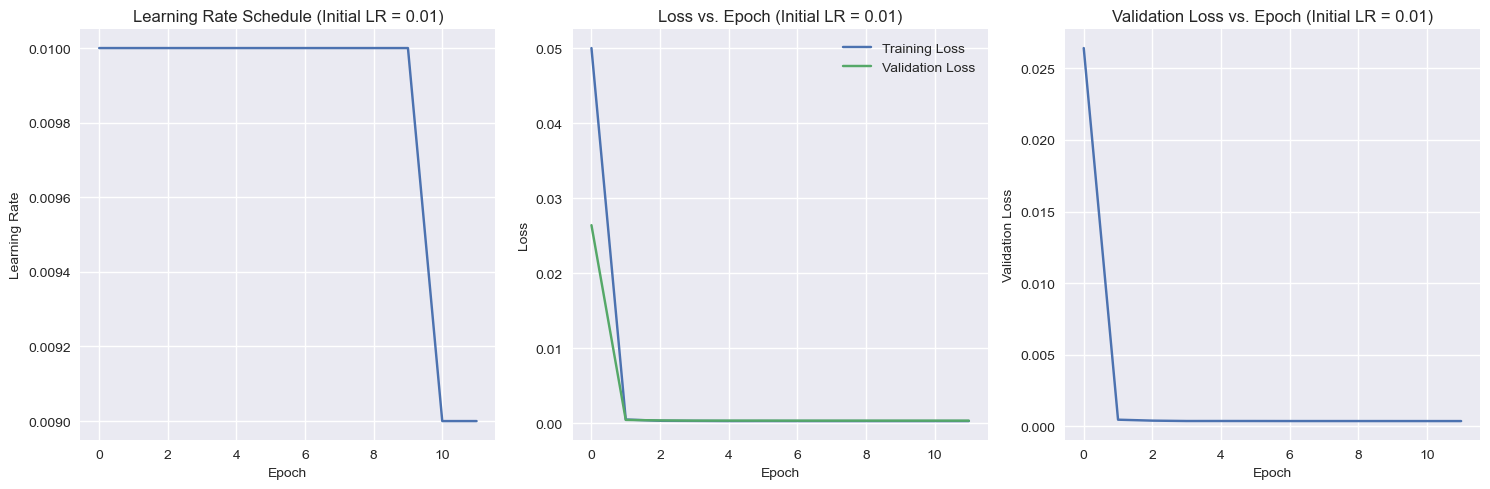


Training with initial learning rate: 0.1


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 155)            620       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1368064   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3601782 (13.74 MB)
Trainable params: 3601472 (13.74 MB)
Non-trainable params: 310 (1.21 KB)
______________

6/6 [==============================] - 1s 221ms/step - loss: 3.0602e-04 - root_mean_squared_error: 0.0247 - mae: 0.0150 - val_loss: 3.6136e-04 - val_root_mean_squared_error: 0.0268 - val_mae: 0.0158 - lr: 0.0900
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 3.0448e-04 - root_mean_squared_error: 0.0244 - mae: 0.0148
Epoch 16: Learning Rate = 0.09000000357627869, Loss = 0.00030447568860836327

Epoch 16: val_loss did not improve from 0.00036
6/6 [==============================] - 1s 219ms/step - loss: 3.0448e-04 - root_mean_squared_error: 0.0244 - mae: 0.0148 - val_loss: 3.6055e-04 - val_root_mean_squared_error: 0.0269 - val_mae: 0.0158 - lr: 0.0900
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 3.0457e-04 - root_mean_squared_error: 0.0247 - mae: 0.0149
Epoch 17: Learning Rate = 0.09000000357627869, Loss = 0.00030456919921562076

Epoch 17: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 590ms/step - loss: 3.0457e-04 - root_mean_squared_error: 0.0247 - mae: 0.0149 - val_loss: 3.6019e-04 - val_root_mean_squared_error: 0.0262 - val_mae: 0.0158 - lr: 0.0900
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 3.0396e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148
Epoch 18: Learning Rate = 0.09000000357627869, Loss = 0.000303959270240739

Epoch 18: val_loss improved from 0.00036 to 0.00036, saving model to best_model_v2
INFO:tensorflow:Assets written to: best_model_v2/assets


INFO:tensorflow:Assets written to: best_model_v2/assets


6/6 [==============================] - 3s 551ms/step - loss: 3.0396e-04 - root_mean_squared_error: 0.0246 - mae: 0.0148 - val_loss: 3.5996e-04 - val_root_mean_squared_error: 0.0274 - val_mae: 0.0160 - lr: 0.0900


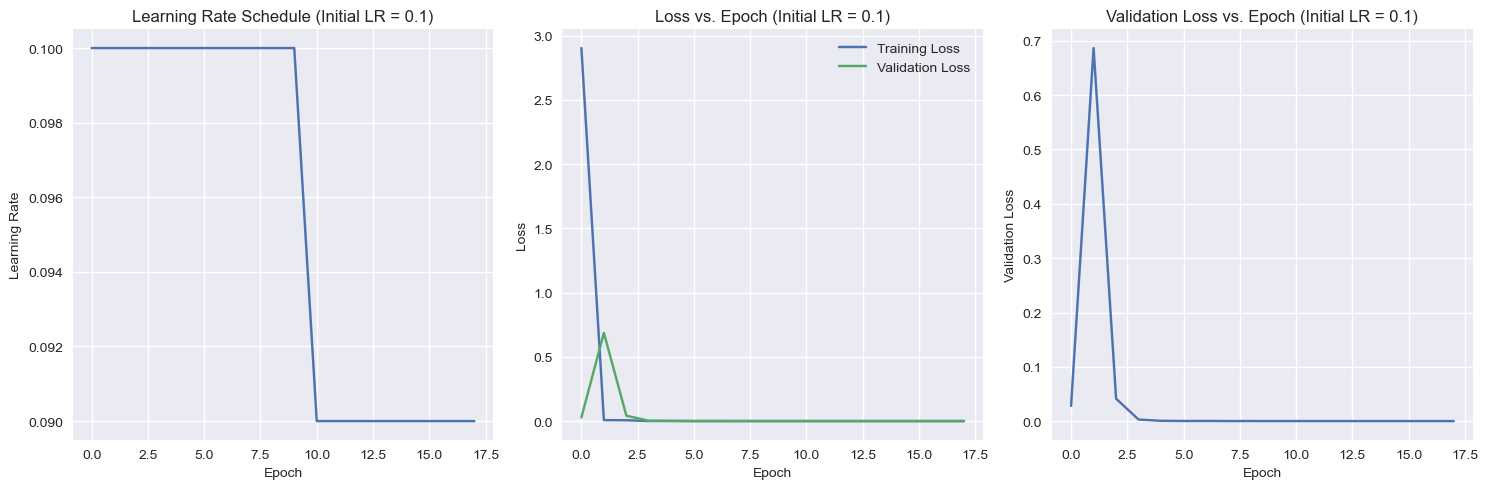

/Users/inderkaur/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
restore_best_weights=False,  # Restore the best weights when stopping
min_delta=0.0001)

checkpont_rnn = ModelCheckpoint(
    filepath='best_model_v2',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    mode='min',
    save_best_only = True,
    verbose = 1)

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
#         print(f"Learning Rate = {lr.numpy()}")
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")
# 

# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

def build_model(initial_lr=0.001):
    model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
    LSTM(512,name='LSTM_2'),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])
    optimizer = Adam(learning_rate=initial_lr)
    
    model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)
    
    return model_1


def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    if epoch<decay_epochs:
        return initial_lr
    elif epoch%decay_epochs!=0:
        return initial_lr
    else:
        return initial_lr * (decay_factor ** (epoch // decay_epochs))

# learning schedule callback
lr_rate = LearningRateScheduler(lr_schedule)
# print(lr_rate.numpy())
callbacks_list = [lr_rate,loss_lr_callback, early_stopping, checkpont_rnn]
callbacks_list



# Define a list to store validation losses for each learning rate


# List of initial learning rates to try
initial_learning_rates = [0.001,0.01,0.1]


best_model = None
best_val_loss = float('inf')
validation_losses = []
num_epochs=100
for lr in initial_learning_rates:
    
    print(f"\nTraining with initial learning rate: {lr}")
    model_1 = build_model(initial_lr=lr)
    print(model_1.summary())

    history = model_1.fit(my_window.train,
                          epochs=num_epochs,
                          callbacks=callbacks_list,
                          verbose=1,
                          validation_data=my_window.val)
    
    # Get the final validation loss for this learning rate
    # Get the final validation loss for this learning rate
    final_val_loss = history.history['val_loss'][-1]
    validation_losses.append(final_val_loss)

    last_epoch = len(history.history['loss'])

# plt.plot(np.arange(1, last_epoch+1), history.history['loss'], label='Loss', lw=3)
# plt.plot(np.arange(1, last_epoch+1), history.history['val_loss'], label='val_loss', lw=3)


    # Plot learning rate vs. epoch
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(history.history['loss'])), history.history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule (Initial LR = {lr})')

    # Plot epoch vs. loss
    plt.subplot(1, 3, 2)
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs. Epoch (Initial LR = {lr})')

    # Plot epoch vs. validation loss
    plt.subplot(1, 3, 3)
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss vs. Epoch (Initial LR = {lr})')

    plt.tight_layout()
    plt.show()
    
    # Check if this model has the best validation loss
    if final_val_loss < best_val_loss:
#         best_val_loss = final_val_loss
        best_lr = lr
        best_val_loss = final_val_loss
        best_model = model_1

# Save the best model
if best_model is not None:
    best_model.save('best_model_v2.h5')


In [43]:
print(f'\nBest Learning Rate: {best_lr}, Best Validation Loss: {best_val_loss}')



Best Learning Rate: 0.1, Best Validation Loss: 0.00035996059887111187


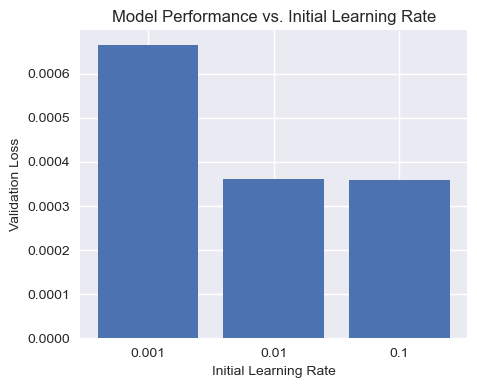

In [44]:
plt.figure(figsize=(5, 4))
# Plot the performance of each initial learning rate
plt.bar([str(lr) for lr in initial_learning_rates], validation_losses)
plt.xlabel('Initial Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Model Performance vs. Initial Learning Rate')
plt.show()

In [45]:
[str(lr) for lr in initial_learning_rates], validation_losses

(['0.001', '0.01', '0.1'],
 [0.0006649645511060953, 0.0003603224758990109, 0.00035996059887111187])

In [46]:
from tensorflow.keras.models import load_model

final_model = load_model('best_model_v2.h5')

In [47]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 155)            620       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1368064   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3601782 (13.74 MB)
Trainable params: 3601472 (13.74 MB)
Non-trainable params: 310 (1.21 KB)
______________

In [48]:
final_model.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 327ms/step - loss: 2.2068e-04 - root_mean_squared_error: 0.0210 - mae: 0.0148


[0.00022067596728447825, 0.021008379757404327, 0.01475248858332634]

In [53]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(10,7)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    
#     for ticker in tickers:
#         print("&&&&&&&&&&&&&&&&&&")
#         print(ticker)
#         print(y_hat.shape[1])
    for n in range(y_hat.shape[1]):
        print(n)
        print(tickers[n])
        plt.figure(figsize=figsize)
        plt.subplot(y_hat.shape[1],1,n+1)
        plt.ylabel('Return')
        plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
        plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
        plt.title(tickers[n])
        plt.legend()

In [54]:
tickers

['DIS', 'BIIB', 'PGR', 'SWK', 'PEP', 'ZION', 'LUV', 'BBWI', 'TFC', 'CBRE']

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 63ms/step
printing y hat of plot_window function
[[0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 ...
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]]
printing y of plot_window function
[[ 1.0380824e-02  7.7600447e-03 -1.1479479e-02 ...  8.7080374e-03
   2.6159908e-03 -7.0250835e-03]
 [ 3.7100874e-03  6.0353992e-03 -2.5807798e-03 ...  5.0361049e-03
   2.3722306e-03  2.3401378e-02]
 [-4.5494335e-03  2.1721127e-0

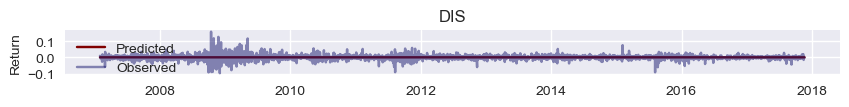

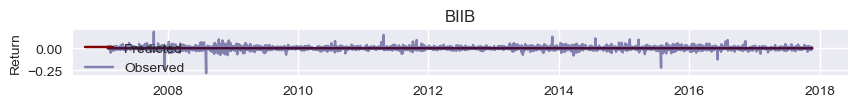

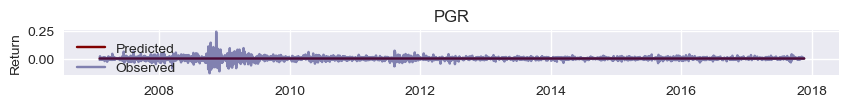

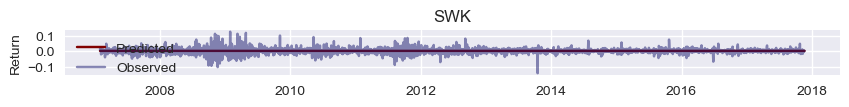

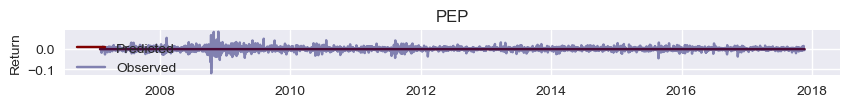

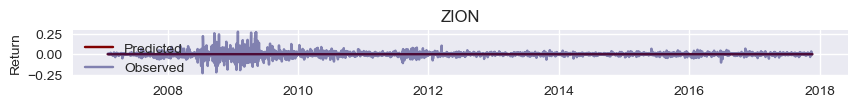

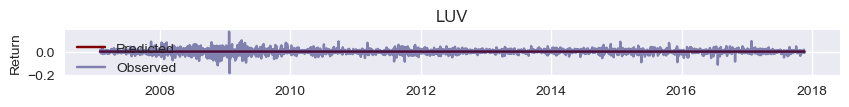

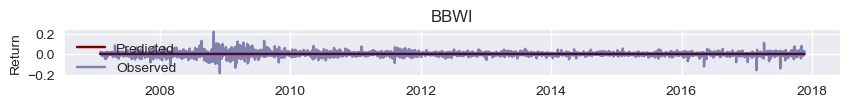

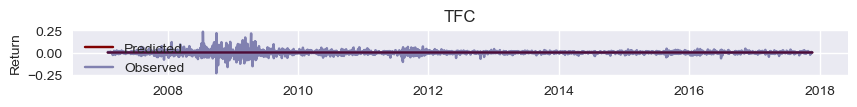

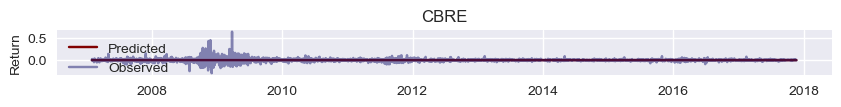

In [55]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(tickers,my_window_2.train,train_df,window_size,final_model)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 90ms/step
printing y hat of plot_window function
[[0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 ...
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]
 [0.00106523 0.00033817 0.00069402 ... 0.00130646 0.00081635 0.00038588]]
printing y of plot_window function
[[ 0.00103712 -0.00919585  0.00820407 ... -0.00586881 -0.00634369
   0.00286853]
 [ 0.02952861 -0.01904458 -0.00193259 ... -0.00359348  0.01149164
   0.00063564]
 [-0.00872189 -0.00282608 -0.00438218 ... -0.03168472 -0.01704168


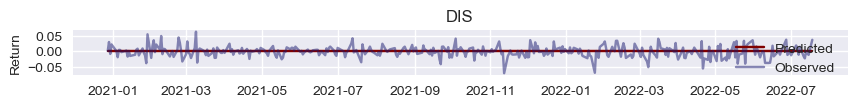

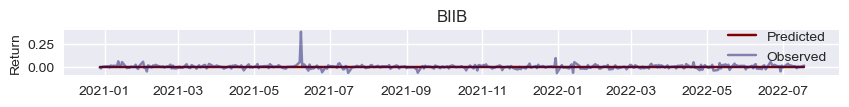

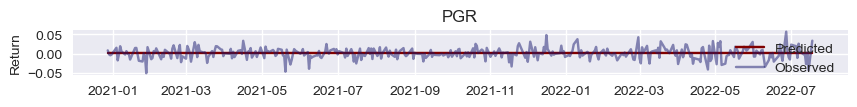

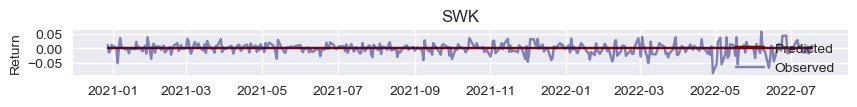

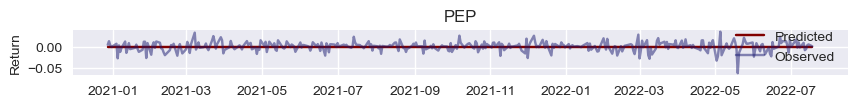

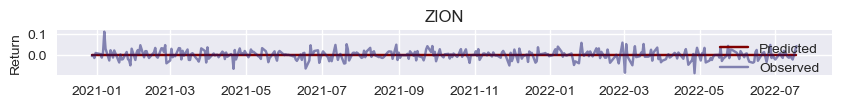

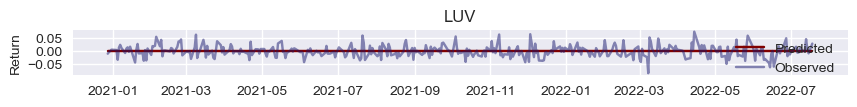

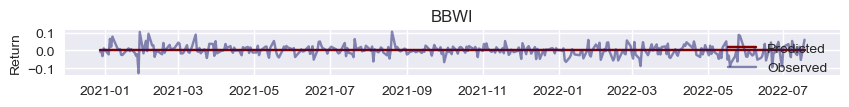

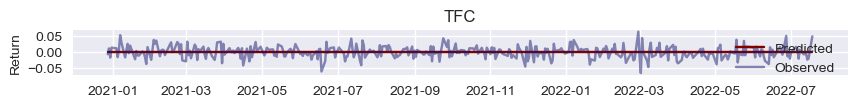

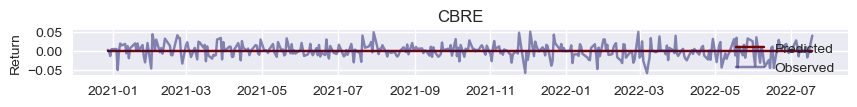

In [56]:
plot_window(tickers,my_window_2.test,test_df,window_size,final_model)

In [57]:
def optimize_portfolio(returns,guess_weights=None,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
#     print("KIIIIIIII")
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    
    bounds = [(0,1) for i in range(num_assets)]
    

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
#     print("sharpe ratio:::::::::::")
#     print(sharpe_ratio)
#     print("returns:::::::::::::::")
#     print(returns)
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

In [58]:
def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

In [59]:
def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [60]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = final_model.predict(my_window_2.train)
y_val = final_model.predict(my_window_2.val)
y_test = final_model.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=model_data.index[5:],columns=columns)
rfr = data_quandl['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')

opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
opt_weights.shape

# opt_weights = np.array([optimize_portfolio(
#     returns=ret_hat_df[ret_hat_df.columns[:-1]],  # Exclude 'rfr' column
#     rfr=ret_hat_df['rfr']
# ).x])

# opt_weights = opt_weights.squeeze()  # Remove extra dimension if it exists

# Display the shape of opt_weights
print(f"Shape of optimized weights: {opt_weights.shape}")


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 61ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
2/2 [==============================] - 0s 47ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 155), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 98ms/step


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_5407/1113877454.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std
/Users/inderkaur/anaconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Shape of optimized weights: (3893, 10)


In [61]:
model_data.shape

(3898, 155)

In [62]:
opt_weights

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])